## Аналитика в Яндекс.Афише

В данном проекте перед нами стоит задача помочь маркетологам оптимизировать маркетинговые затраты. В распоряжении есть данные от Яндекс.Афиши с 1 июня 2017 по 31 мая 2018 года:

* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Нужно изучить:

1. Как люди пользуются продуктом,
2. Когда они начинают покупать,
3. Сколько денег приносит каждый клиент
4. Когда клиент окупается.

## Содержание проекта:
* 1 [Загрузка и подготовка данных](#m1)
    * 1.1 [Чтение таблиц](#m1.1)
    * 1.2 [Замена типа данных](#m1.2)
    * 1.3 [Проверка дубликатов и уникальных значений](#m1.3)
* 2 [Отчеты и метрики](#m2)
    * 2.1 [Продукт](#m2.1)
        * 2.1.1 [Сколько людей пользуются в день/неделю/месяц?](#m2.1.1)
        * 2.1.2 [Сколько сессий в день?](#m2.1.2)
        * 2.1.3 [Длительность одной сессии](#m2.1.3)
        * 2.1.4 [Как часто люди возвращаются?](#m2.1.4)
    * 2.2 [Продажи](#m2.2)
        * 2.2.1 [Когда люди начинают покупать?](#m2.2.1)
        * 2.2.2 [Сколько раз покупают за период?](#m2.2.2)
        * 2.2.3 [Какой средний чек?](#m2.2.3)
        * 2.2.4 [Сколько денег приносят (LTV)?](#m2.2.4)
    * 2.3 [Маркетинг](#m2.3)
        * 2.3.1 [Сколько денег потрчаено?](#m2.3.1)
        * 2.3.2 [Стоимость привлечения одного покупателя](#m2.3.2)
        * 2.3.3 [На сколько окупились расходы? (ROI)](#m2.3.3)
* 3 [Общий вывод](#m3)

<div class="alert alert-block alert-success">
    

### Комментарий от ревьюера №1

Хорошее начало с названием проекта, описанием и интерактивным оглавлением.
</div>

## Загрузка и подготовка данных <a name="m1"></a>

In [268]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore")

### Чтение таблиц <a name="m1.1"></a>

In [269]:
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [270]:
display(visits)
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Таблица **visits** (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

In [271]:
display(orders)
orders.info()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Таблица **orders** (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

In [272]:
display(costs)
costs.info()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

### Замена типа данных <a name="m1.2"></a>

In [273]:
visits.columns = ['device','end_ts', 'source_id', 'starts_ts', 'uid']
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['starts_ts'] = pd.to_datetime(visits['starts_ts'])
# перевод к нужному типу данных
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   starts_ts  359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [274]:
orders.columns = ['buy_ts', 'revenue', 'uid']
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


В датафрейме costs аккуратные названия столбцов, но нужно изменить тип данных в dt (дате).

In [275]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


### Проверка дубликатов и уникальных значений <a name="m1.1"></a>

In [276]:
visits['device'].unique()

array(['touch', 'desktop'], dtype=object)

In [277]:
visits.duplicated().sum()

0

In [278]:
orders.duplicated().sum()

0

In [279]:
costs.duplicated().sum()

0

### Шаг 2. Постройте отчёты и посчитайте метрики <a name="m2"></a>

### Продукт <a name="m2.1"></a>

**Сколько людей пользуются в день, неделю, месяц?** <a name="m2.1.1"></a>

Расчитываем dau, wau, mau

In [280]:
first_visit_date = visits.groupby('uid')['starts_ts'].min() 
first_visit_date.name = 'first_visit_date'
visits = visits.join(first_visit_date,on='uid')
visits['first_visit_date'] = visits['first_visit_date'].dt.date
visits['first_visit_date'] = pd.to_datetime(visits['first_visit_date'])
# добавили дату первого посещения в таблицу
visits['week'] = visits['starts_ts'].dt.week 
# добавили недели в таблицу
visits['month'] = visits['starts_ts'].dt.month
# добавили месяца в таблицу
visits['day'] = visits['starts_ts'].dt.date
visits 

,device,end_ts,source_id,starts_ts,uid,first_visit_date,week,month,day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09,20,5,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017-12-27
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,30,7,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,4,1,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,9,3,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,44,11,2017-11-02


In [281]:
def day(df, title, ylabel, legend):
    dau_plot = df.plot(figsize=(15,8), color = 'darkgreen', linewidth = 2, grid=True);
    dau_plot.set_title(f'{title}', fontsize=15);
    dau_plot.set_xlabel('Days', fontsize=13);
    dau_plot.set_ylabel(f'{ylabel}', fontsize=13);
    dau_plot.xaxis.set_major_locator(ticker.MultipleLocator(30));
    dau_plot.legend([f'{legend}'], prop={'size': 15});
# построение dau графика

def week(df, title, ylabel, legend):
    wau_plot = df.plot(figsize=(15,8), color = '#0485d1', linewidth = 2, marker = 'o', grid=True);
    wau_plot.set_title(f'{title}', fontsize=15);
    wau_plot.set_xlabel('Weeks', fontsize=13);
    wau_plot.set_ylabel(f'{ylabel}', fontsize=13);
    wau_plot.xaxis.set_major_locator(ticker.MultipleLocator(5));
    wau_plot.legend([f'{legend}'], prop={'size': 15}, loc='best');
# построение wau графика

def month(df, title, ylabel, legend):
    mau_plot = df.plot(figsize=(15,8), color = 'maroon', linewidth = 2, marker = 'o', grid=True);
    mau_plot.set_title(f'{title}', fontsize=15);
    mau_plot.set_xlabel('Months', fontsize=13);
    mau_plot.set_ylabel(f'{ylabel}', fontsize=13);
    mau_plot.xaxis.set_major_locator(ticker.MultipleLocator(1));
    mau_plot.legend(['visits'], prop={'size': 15}, loc='best');
# построение mau графика

In [282]:
dau = visits.groupby('day').agg({'uid':'nunique'})
wau = visits.groupby('week').agg({'uid':'nunique'})
mau = visits.groupby('month').agg({'uid':'nunique'})

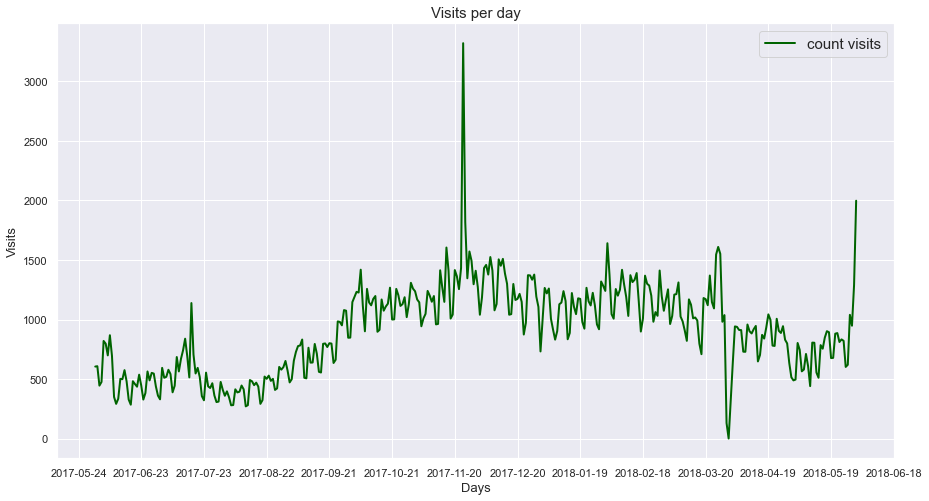

In [283]:
day(dau, 'Visits per day', 'Visits', 'count visits')

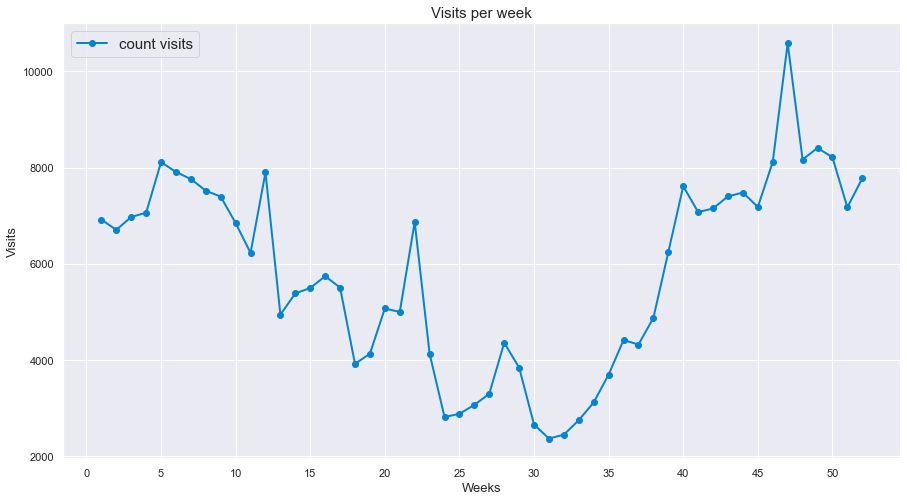

In [284]:
week(wau, 'Visits per week', 'Visits', 'count visits')

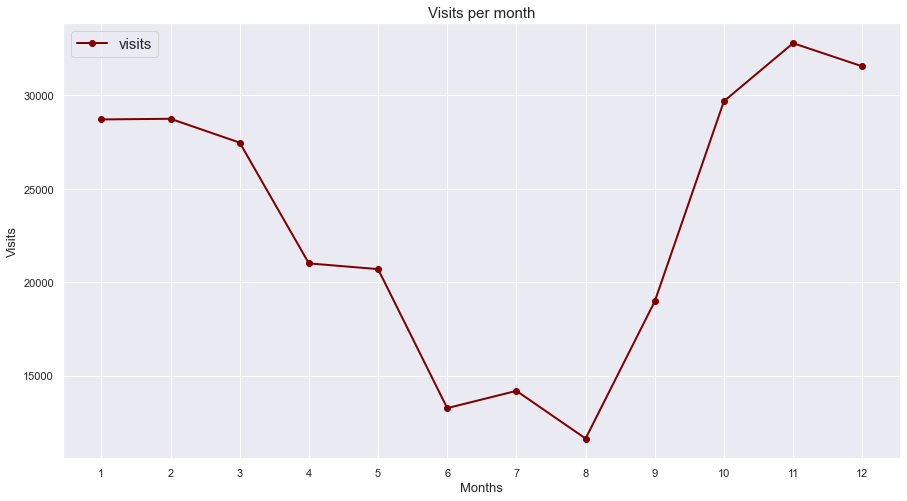

In [285]:
month(mau, 'Visits per month', 'Visits', 'count visits')

Вывод по графикам:
1. В графике по ежедневным визитам (уникальным пользователям) видны скачок между ноябрем и декабрем, а также скачок к концу мая. Скорее всего скачки обусловлены предверием Нового года с Новогодними елками, а также конец учебного года с различными детскими развлечениями. Также видно, что летний сезон по сравнению с остальными сезонами менее посещаемый. На данном этапе есть лишь предположение о том, что детских развлечений как таковых нет (большинство детей в лагерях и прочее), а билеты на летние музыкальные фестивали покупаются как раз с осени по весну.
2. В графике по еженедельным визитам также видна просадка в середине (это как раз наше лето). И скачки ближе к просадке (весна) и в конце недель (декабрь месяц). График читается так, что 0-я неделя - это январь 2018, а последняя неделя - это декабрь  2017. Возможно можно было сделать удобно, но у нас дан один календарный год и вроде удобно и так.
3. В графике ежемесячном все те же прсадки и скачки. Однако нет такого выраженного скачка перед летом. График выглядит как  немного побитая парабола.

Ниже также представила среднее количество пользователей в день, неделю и месяц.

In [286]:
print('Визитов в день в среднем:', int(dau.mean()))
print('Визитов в неделю в среднем:', int(wau.mean()))
print('Визитов в месяц в среднем:', int(mau.mean()))

Визитов в день в среднем: 907
Визитов в неделю в среднем: 5825
Визитов в месяц в среднем: 23228


В девайсах я решила смотреть графики на одной плоскости, параллельно сравнивая как себя ведут два разных устройства.

In [287]:
visits_touch = visits[visits['device'] == 'touch']
visits_desktop = visits[visits['device'] == 'desktop']
# desktop и touch заходы ежедневно
dau_desktop = visits_desktop.groupby("day").agg({'uid':'nunique'})
dau_touch = visits_touch.groupby("day").agg({'uid':'nunique'})
# desktop и touch заходы еженедельно
wau_desktop = visits_desktop.groupby('week').agg({'uid':'nunique'})
wau_touch = visits_touch.groupby('week').agg({'uid':'nunique'})
# desktop и touch заходы ежемесячно
mau_desktop = visits_desktop.groupby('month').agg({'uid':'nunique'})
mau_touch = visits_touch.groupby('month').agg({'uid':'nunique'})

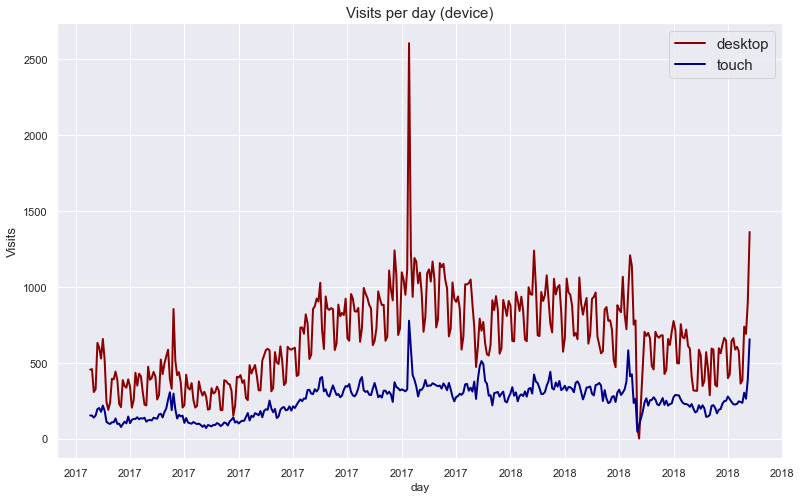

In [288]:
dvd = dau_desktop.plot(figsize=(13,8), color = 'darkred', linewidth = 2, grid=True);
dvd.set_title('Visits per day (device)', fontsize=15);
dvd.set_ylabel('Visits', fontsize=13);
dvd.xaxis.set_major_locator(ticker.MultipleLocator(30));
dvt = dau_touch.plot(figsize=(13,8), color = 'darkblue', linewidth = 2, grid=True, ax = dvd);
dvd.legend(['desktop', 'touch'], prop={'size': 15});

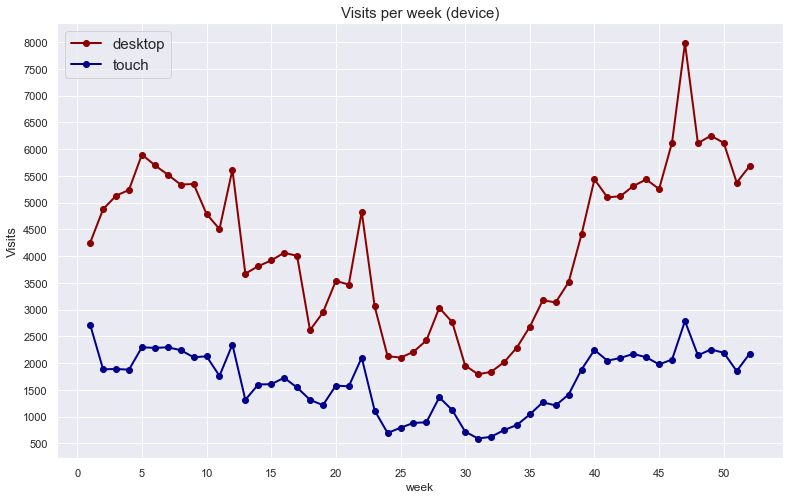

In [289]:
wvd = wau_desktop.plot(figsize=(13,8), color = 'darkred', linewidth = 2, marker = 'o', grid=True);
wvd.set_title('Visits per week (device)', fontsize=15);
wvd.set_ylabel('Visits', fontsize=13);
wvd.xaxis.set_major_locator(ticker.MultipleLocator(5));
wvd.yaxis.set_major_locator(ticker.MultipleLocator(500));
wau_touch.plot(figsize=(13,8), color = 'darkblue', linewidth = 2, marker = 'o', grid=True, ax = wvd);
wvd.legend(['desktop', 'touch'], prop={'size': 15}, loc='best');

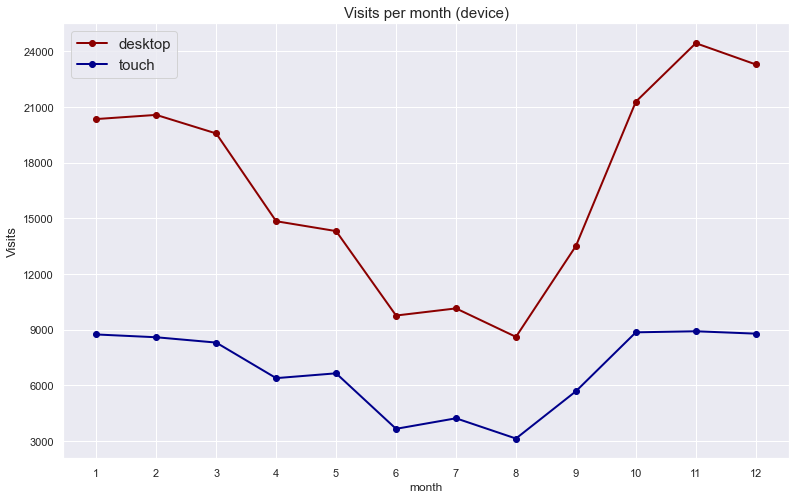

In [290]:
mvd = mau_desktop.plot(figsize=(13,8), color = 'darkred', linewidth = 2, marker = 'o', grid=True);
mvd.set_title('Visits per month (device)', fontsize=15);
mvd.set_ylabel('Visits', fontsize=13);
mvd.xaxis.set_major_locator(ticker.MultipleLocator(1));
mvd.yaxis.set_major_locator(ticker.MultipleLocator(3000));
mau_touch.plot(figsize=(13,8), color = 'darkblue', linewidth = 2, marker = 'o', grid=True, ax = mvd);
mvd.legend(['desktop', 'touch'], prop={'size': 15}, loc='best');

Вывод по графикам:

1. Наши графики вышли иднетичны общим графикам. Просадки в тех же моментах, взлеты в тех же моментах. 
2. Явно видно, что пользователи предпочитают посещать с desktop, а не touch. Разница в посещениях в два раза минимум.

Ниже представила среднее количество визитов в день, неделю и месяц.

In [291]:
print('Визитов в день в среднем на desktop',int(dau_desktop.mean()), 'и на touch', int(dau_touch.mean()))
print('Визитов в неделю в среднемна desktop',int(wau_desktop.mean()), 'и на touch', int(wau_touch.mean()))
print('Визитов в месяц в среднемна desktop',int(mau_desktop.mean()), 'и на touch', int(mau_touch.mean()))

Визитов в день в среднем на desktop 659 и на touch 252
Визитов в неделю в среднемна desktop 4208 и на touch 1666
Визитов в месяц в среднемна desktop 16724 и на touch 6825


Сначала я хотела визуализировать рекламные источники ящиком с усами, а потом передумала и решила просто сделать 3 табличчки со средними показаниями за день, неделю и месяц.

In [292]:
# ДЕЛАЕМ ПО ДНЯМ
dau_source = visits.groupby(['source_id', "day"]).agg({'uid':'nunique'}).reset_index()
dau_source = dau_source.pivot_table(index = 'day',
                              columns = 'source_id',
                              values = 'uid').fillna(0)
# ДЕЛАЕМ ПО НЕДЕЛЯМ
wau_source = visits.groupby(['source_id', 'week']).agg({'uid':'nunique'}).reset_index()
wau_source = wau_source.pivot_table(index = 'week',
                              columns = 'source_id',
                              values = 'uid').fillna(0)
# ДЕЛАЕМ ПО МЕСЯЦАМ
mau_source = visits.groupby(['source_id', 'month']).agg({'uid':'nunique'}).reset_index()
mau_source = mau_source.pivot_table(index = 'month',
                              columns = 'source_id',
                              values = 'uid').fillna(0)

In [293]:
print('Среднее кол-во визитов ежедневно:')
print(dau_source.mean())
print()
print('Среднее кол-во визитов еженедельно:')
print(wau_source.mean())
print()
print('Среднее кол-во визитов ежемесячно:')
print(mau_source.mean())
print()

Среднее кол-во визитов ежедневно:
source_id
1      80.557692
2     120.376374
3     232.225275
4     274.697802
5     175.140110
6       0.016484
7       0.098901
9      36.010989
10     25.961538
dtype: float64

Среднее кол-во визитов еженедельно:
source_id
1      472.173077
2      729.192308
3     1596.000000
4     1864.365385
5     1189.903846
6        0.115385
7        0.692308
9      243.288462
10     169.750000
dtype: float64

Среднее кол-во визитов ежемесячно:
source_id
1     1818.750000
2     2752.083333
3     6758.833333
4     7765.666667
5     5017.916667
6        0.500000
7        2.833333
9      987.000000
10     707.000000
dtype: float64



Вывод:

1. Из наших табличек можно сделать вывод, что источники 6 и 7 совсем не популярны. Подумав, я решила, что оставлю эти источники до момента, когда будем анализировать продажи. Если продаж по источникам не будет, то источник не учитываю и в выводе общем напишу "источник себя совсем не окупает", если будет одна продажа, то буду смотреть по обстоятельствам. Но скорее всего источник тоже себя не окупает.
2. Источники 3-5 - самые популярные по визитам, но популярны ли они по продажам - не знаю.
3. Источники 1-2 - это вторая по популярности группа источников, посмотрим, сколько продаж они приносят.
4. Источники 9-10 предпоследние попопулярности, но все также зависит от продаж.

В этом проекте я решила, что нам важны не пустые заходы, а продажи. Если бы у нас был сервис с какой-то монетизацией (к примеру мы бы рекламировали свой twitch канал), то там важны заходы, поскольку реклама настроена на то, чтобы человек зашел, заинтересовался и подписался (а не что-то купил). В нашем случае мы привлекаем продажи, потому что окупаемость рекламы можно оценить лишь по тому, сколько продаж (прибыль) с нее пришло.


**Сколько сессий в день?** <a name="m2.1.2"></a>

Сессии в день буду смотреть по общим данным. Возможно и по девайсам, но буду смотреть по факту уже оценивать так или нет.

In [294]:
new_visits = visits[visits['end_ts'] > visits['starts_ts']]
new_visits # делаем срез, чтобы начало сесии было раньше конца сессии

,device,end_ts,source_id,starts_ts,uid,first_visit_date,week,month,day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018-02-19
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09,20,5,2018-05-20
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017-09-03,35,9,2017-09-03
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2017-06-29,5,1,2018-01-30
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017-07-29,30,7,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018-01-25,4,1,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018-03-03,9,3,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017-11-02,44,11,2017-11-02


In [295]:
rows = len(visits)
new_rows = len(new_visits)
precent_rows = new_rows / rows
print('Процент оставшихся строчек в df: {:.1%}'.format(precent_rows))

Процент оставшихся строчек в df: 90.0%


10% нашего датафрейма содержат строки, где конец сессии произошел раньше начала сессии. Скорее всего ошибка в сборе данных.

In [296]:
mean_sessions = new_visits.groupby(['month', pd.Grouper(key="starts_ts", freq="D")]).agg({'uid':['count', 'nunique']})
mean_sessions.columns = ['n_sessions', 'n_users']
mean_sessions['sessions_per_user'] = mean_sessions['n_sessions'] / mean_sessions['n_users']
mean_sessions

n_sessions  n_users  sessions_per_user
month starts_ts                                         
1     2018-01-01         971      907           1.070562
      2018-01-02        1241     1156           1.073529
      2018-01-03        1201     1114           1.078097
      2018-01-04        1221     1128           1.082447
      2018-01-05         998      918           1.087146
...                      ...      ...                ...
12    2017-12-27        1291     1197           1.078530
      2017-12-28        1356     1250           1.084800
      2017-12-29        1187     1081           1.098057
      2017-12-30        1086     1012           1.073123
      2017-12-31         708      664           1.066265

[364 rows x 3 columns]

По нашей таблице среднего количества сессий видно, что количество уникальных (n_users) меньше количества сессий (n_sessions), но не сильно. Рядом также добавила столбец, где высчитала среднее количество визитов одного пользователя в день. Посмотрим по сводной таблице теперь среднее количество заходов пользователя в день с разбивкой по месяцу. 

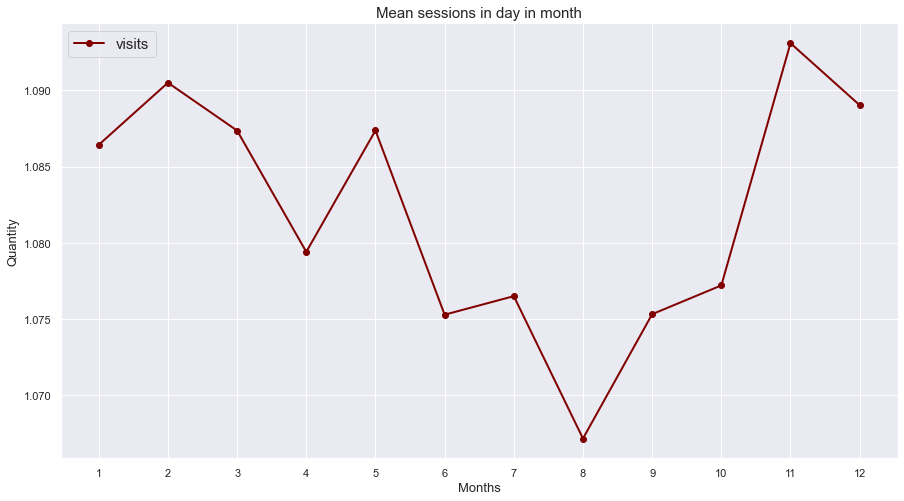

In [297]:
month(mean_sessions_pivot, 'Mean sessions in day in month', 'Quantity', 'sessions')

График напоминает наш график визитов, но и не удивительно. В принципе можно было ожидать, что в какой-то день люди пришли вне себя и начали заходить по 10 раз на дню, но такого нет. И в среднем люди заходят все же 1 раз, максимум 2 заходят единицы. Значит ли это, что люди заходят целенаправленно? Возможно. Видимо реклама работает так, что человек либо сразу находит то, что ему надо, либо не находит уходит. А какая-то небольшая часть заходит потом повторно, может меняет девайс или заходят через месяц, когда появляются деньги.

По девайсам я решила не смотреть. Мы и так знаем, что touch менее популярен desktop, а из общей таблицы сессий видно, что больше одного раза заходят единицы. Ничего нового мы не увидим, как мне кажется.

**Длительность одной сессии** <a name="m2.1.3"></a>

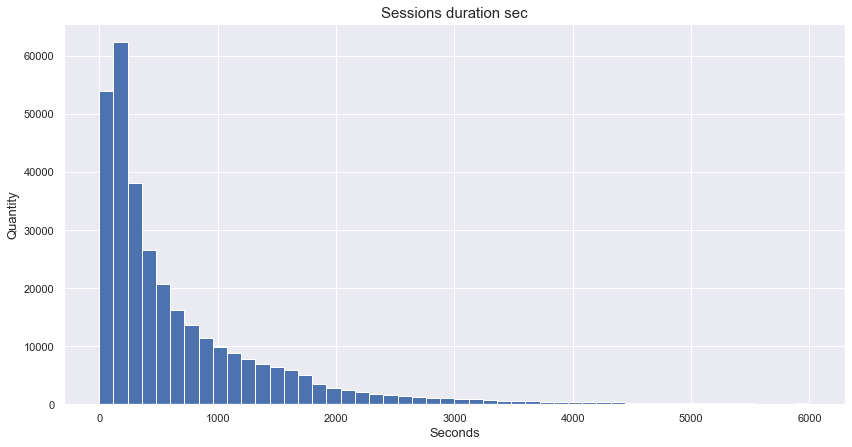

In [298]:
new_visits['session_duration_sec'] = (new_visits['end_ts'] - new_visits['starts_ts']).dt.seconds
sds = new_visits['session_duration_sec'].hist(bins=50, figsize=(14,7), range=(0,6000));
sds.set_title('Sessions duration sec', fontsize=15);
sds.set_xlabel('Seconds', fontsize=13);
sds.set_ylabel('Quantity', fontsize=13);

Для гистограммы использовала наш датафрейм визитов, где мы убрали конец сессий раньше начала сессии. То есть продолжаем работать с "правильными" данными. На графике видны пики, но длительность одной сессии в среднем мы тут не рассмотрим. Зато рассмотрим, что график не нормального распределения и будем использовать mode.

In [299]:
print(new_visits['session_duration_sec'].mode()) 

0    60
dtype: int64


In [300]:
visits_touch = new_visits[new_visits['device'] == 'touch']
visits_desktop = new_visits[new_visits['device'] == 'desktop']
print('Длительность сессии desktop:')
print(visits_desktop['session_duration_sec'].mode()) 
print()
print('Длительность сессии touch:')
print(visits_touch['session_duration_sec'].mode()) 

Длительность сессии desktop:
0    60
dtype: int64

Длительность сессии touch:
0    60
dtype: int64


Ради интереса посмотрела длительность сессий по девайсам. Мало ли есть какие-то отличия, мало ли что-то популярнее, а что-то - нет. Но отличий не оказалось.

По рекламным источникам не смотрю, нам неважно сколько человек провел времени с источника. Нам важно поведние (купил или нет) с источника и окупился ли источник.

In [301]:
new_visits['session_duration_sec'].describe()

count    323604.000000
mean        714.169516
std        1026.349417
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

In [302]:
visits_desktop['session_duration_sec'].describe()

count    238876.000000
mean        773.058516
std        1094.323526
min          19.000000
25%         120.000000
50%         420.000000
75%        1020.000000
max       42660.000000
Name: session_duration_sec, dtype: float64

In [303]:
visits_touch['session_duration_sec'].describe()

count    84728.000000
mean       548.142125
std        780.801668
min         19.000000
25%        120.000000
50%        240.000000
75%        720.000000
max      30840.000000
Name: session_duration_sec, dtype: float64

**Как часто люди возвращаются?** <a name="m2.1.4"></a>

In [304]:
visits['activity_month'] = visits['starts_ts'].astype('datetime64[M]')
visits['first_activity_month'] = visits['first_visit_date'].astype('datetime64[M]')
# создали дополнительные столбцы, где будет месяц активности и первой активности
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int') 
# расчитали cohort_lifetime и привели к нужному типу
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 
# сгруппировали когорты
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count.columns = ['first_activity_month', 'initial_uid']
# создали доп.переменную, в которой оставили дату первой активности и количество пользователей на первую дату активности
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')
# объединили когорты с первоначальными пользователями
cohorts['retention'] = cohorts['uid']/cohorts['initial_uid'] 
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')
# считаем Retention по упрощенной формуле

In [305]:
cohorts

,first_activity_month,cohort_lifetime,uid,initial_uid,retention
0,2017-06,0,13259,13259,1.000000
1,2017-06,1,1043,13259,0.078664
2,2017-06,2,713,13259,0.053775
3,2017-06,3,814,13259,0.061392
4,2017-06,4,909,13259,0.068557
...,...,...,...,...,...
73,2018-03,1,861,20589,0.041818
74,2018-03,2,557,20589,0.027053
75,2018-04,0,15709,15709,1.000000
76,2018-04,1,760,15709,0.048380


In [306]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum') 
# сделали сводную таблицу по retention и вывели ее для наглядности
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


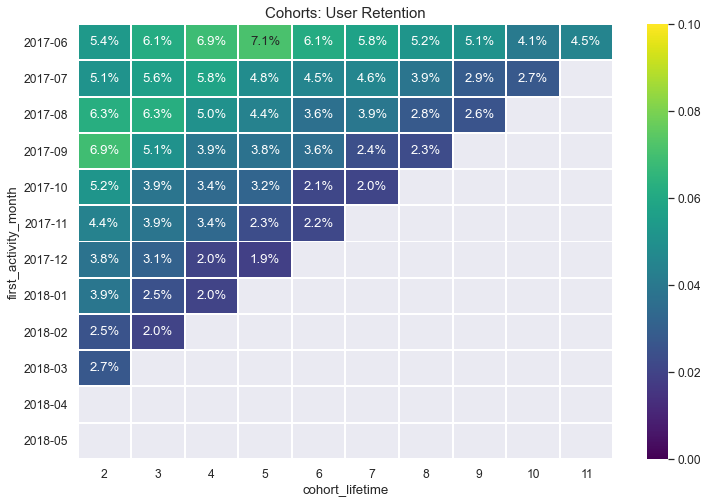

In [345]:
retention_pivot = retention_pivot.iloc[:, 1:12]
sns.set(font_scale=1.1)
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention', fontsize=15)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='white', cmap= 'viridis', vmin=0, vmax=0.1); 

По полученной тепловой карте видно, что люди повторно возвращаются редко. После первого месяца жизни все когорты резко падают. Видимо люди заходят только тогда, когда заинтересованы, а потом пропадают. С другой стороны наш ресурс не такой, чтобы нужно было заходить на него ежемесячно, ведь захотеть куипть билет на концерт можно раз в полгода. Но, если память не подводит, на Яндекс.Афише продаются также билеты в кино, что могло явно отразиться на посещение пользователей. Походы в кино любят все.

Так что 2-9 человека из 100, которые остаются в последующие месяцы, - это грустно.

***Общий вывод по продукту***

Проанализировав продукт с точки зрения пользователей и их заинтересованности можно сделать вывод, что продукт (Яндекс.Афиша) интересует "здесь и сейчас". 

1. Пики визитов происходят перед какими-то праздниками (новый год, конец учебного года). Летом всеобщий спад, музыкальные фестивали начались, а билеты на них покупали с осени по весну.
2. Такая же закономерность происходит и по количеству сессий. Их больше ровно тогда, когда больше уникальных пользователей (визитов).
3. Однако среднее количество сессий от одного пользователя в день неизменно с течением каждого месяца. 
4. После анализа Retention Rate сделали вывод, что удержание 2-9 людей из 100 - это грустно. Стоит подумать о том, какими иными способами происходит информация уже появившихся пользователей, но это другой анализ.
5. Средняя длительность одной сессии 60 секунд или 1 минута, как по мне, малый показатель. Видимо чаще люди заходят, смотрят и выходят? Или они заходят целенаправленно и за минуту успевают купить нужные им билеты? Загадка и для этого нужны дополнительные данные.
6. Также мы посмотрели девайсы и сделали вывод, что desktop более популярный в использовании, чем touch. Но на продолжительность сессии это не влияет. 
7. Сделали первичную оценку рекламных источников, выбрали более посещаемые, менее посещаемые и среднячки.

### Продажи <a name="m2.2"></a>

**Когда люди начинают покупать?** <a name="m2.2.1"></a>

Можно по-разному оценить среднее время между визитом и покупкой. Я решила выбрать вариант оценки времени между первым визитом и первой покупки. Почему именно так? Первый визит для меня - это факт привлечения клиента как пользователя (uid). Дальше пользователь присматривается к продукту или отказывается от него. И если пользователь присмотрелся, то он делает первую покупку. Затраченное время и есть время, отвечающее на вопрос "когда человек начинает покупать?". Мы же будем смотреть усредненное время.

Я думала рассмотреть показатель по девайсам, но подумала, что это нелогично. Человек может зайти с touch, а купить с desktop. Думаю, что девайсы рассмотрим в следующем этапе по количеству покупок и сравним с количеством визитов.

По рекламным источникам думаю, что нет смысл рассмотривать. Если пользователь проибрел товар, то значит он был привлечен правильно. Нам, конечно, важно знать, когда пользователи покупают, но не так важно знать, как они покупают по источникам. Мы рассмотрим общую картину как работают все источники и будем принимать, что везде примерно одинаково.

In [346]:
first_visit = visits.groupby('uid')['starts_ts'].min() 
first_visit.name = 'first_visit'
orders = orders.join(first_visit,on='uid')
# берем у таблицы visits то, что нам нужно, и группируем с нашей таблицейй orders
first_buy = orders.groupby('uid')['buy_ts'].min() 
first_buy.name = 'first_buy'
orders = orders.join(first_buy,on='uid')
# также делаем с еще одним показателям и получаем такую итоговую таблицу
orders

ValueError: columns overlap but no suffix specified: Index(['first_visit'], dtype='object')

In [347]:
new_orders = orders[orders['first_buy'] > orders['first_visit']]
# опять выбираем те данные, когда первая покупка произошла ПОЗЖЕ первого визита. иначе получается бессмыслица
new_orders['time_between'] = (new_orders['first_buy'] - new_orders['first_visit']).dt.total_seconds()/60
new_orders['time_between'] = new_orders['time_between'].astype('int')
# добавляем в таблицу разницу в минутах
new_orders

,buy_ts,revenue,uid,first_visit,first_buy,month,week,day,source_id,buy_month,first_buy_month,cohort_lifetime,time_between
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,6,22,2017-06-01,1,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,6,22,2017-06-01,2,2017-06-01,2017-06-01,0,11
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,6,22,2017-06-01,2,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,6,22,2017-06-01,2,2017-06-01,2017-06-01,0,15
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,6,22,2017-06-01,3,2017-06-01,2017-06-01,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2017-12-07 23:20:00,2018-05-31 23:43:00,5,22,2018-05-31,2,2018-05-01,2018-05-01,0,252023
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,5,22,2018-05-31,4,2018-05-01,2018-05-01,0,879
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,5,22,2018-05-31,10,2018-05-01,2018-05-01,0,45
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,5,22,2018-05-31,3,2018-05-01,2018-05-01,0,2


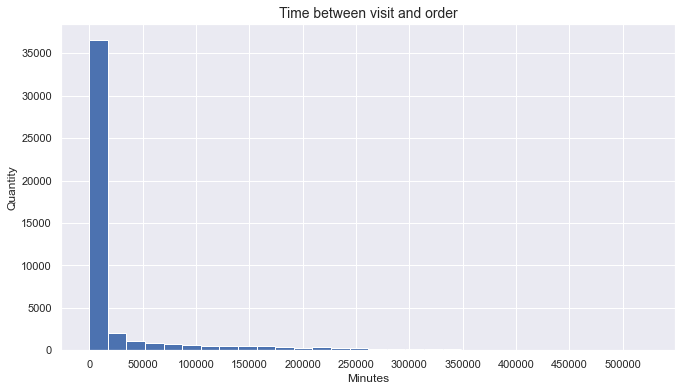

In [348]:
sns.set()
fo = new_orders['time_between'].hist(figsize=(11,6), bins=30);
fo.set_title('Time between visit and order', fontsize=14);
fo.set_xlabel('Minutes', fontsize=12);
fo.set_ylabel('Quantity', fontsize=12);
fo.xaxis.set_major_locator(ticker.MultipleLocator(50000));
fo.yaxis.set_major_locator(ticker.MultipleLocator(5000));

На графике мало что понятно, лишь ясно, что большинство показателей "прижилось" у нуля. Шаг большой. Посмотрим распределение в первые сутки. А потом посмотрим mode и describe.

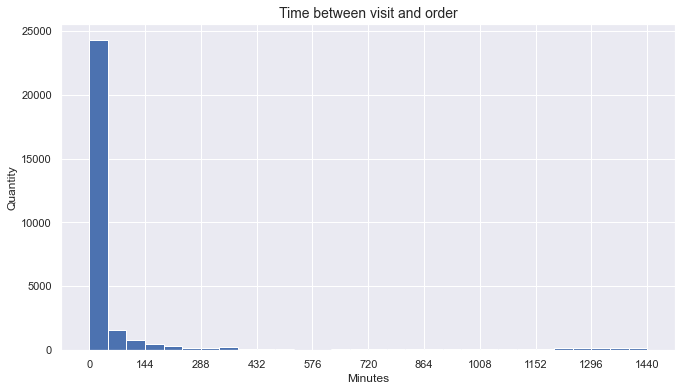

In [349]:
fo = new_orders['time_between'].hist(figsize=(11,6), bins=30, range=(0,1440));
fo.set_title('Time between visit and order', fontsize=14);
fo.set_xlabel('Minutes', fontsize=12);
fo.set_ylabel('Quantity', fontsize=12);
fo.xaxis.set_major_locator(ticker.MultipleLocator(144));
fo.yaxis.set_major_locator(ticker.MultipleLocator(5000));

Все еще большинство показателей прижилось у нуля, а это значит, что где-то в перый час большинство (25000 из 35000) покупателей делают свою покупку.

In [350]:
new_orders['time_between'].describe()

count     46499.000000
mean      27505.486290
std       69248.397094
min           1.000000
25%           6.000000
50%          34.000000
75%        9065.500000
max      523144.000000
Name: time_between, dtype: float64

In [351]:
new_orders['time_between'].mode()

0    1
dtype: int32

А вот изучение данных чуть иначе показало, что чаще всего всетрчается покупка в первую минуту, она же самая быстрая (min) в наших данных. 50% пользователей делают заказ в первые 34 минуты, 75 процентов делают заказ в первые 9063 минуты, но воспользовшись своей головой я узнала, что 75% от 46501 - это больше 25000, так что неудивительно, что такой показатель. На графике явно увидели, что 25000 в первый час покупки делают.

**Сколько раз покупают за период?** <a name="m2.2.2"></a>

Сколько раз покупают я буду смотреть по трем периодам: день, неделя и месяц. Также рассмотрю месячную картину покупок у рекламных источников. Мало ли какие-то источники привлекают только сессии, а не покупки. Также рассмотрю по месячным когортам, чтобы знать какой месяц привлекает более потенциальных клиентов, которые живут с сервисом дальше.

Так как у нас датафрейм до 31.05.2018 23:59:59 (как я поняла), то могут быть случаи, что человек зашел вечером 31.05.2018, а купил в июне 2018. Я уберу такие строки, надеюсь их будет немного. Иначе они либо засчитаются в 12-й месяц, либо будут хвостом.

In [352]:
orders = orders[orders['buy_ts'] < '2018-06-01']

In [353]:
orders['month'] = orders['buy_ts'].dt.month
orders['week'] = orders['buy_ts'].dt.week
orders['day'] = orders['buy_ts'].dt.date
# добавляем месяц, неделю и день
orders_months = orders.groupby('month').agg({'uid':'count'})
orders_weeks = orders.groupby('week').agg({'uid':'count'})
orders_days = orders.groupby('day').agg({'uid':'count'})
# группируем заказы по месяцам, неделям и дням

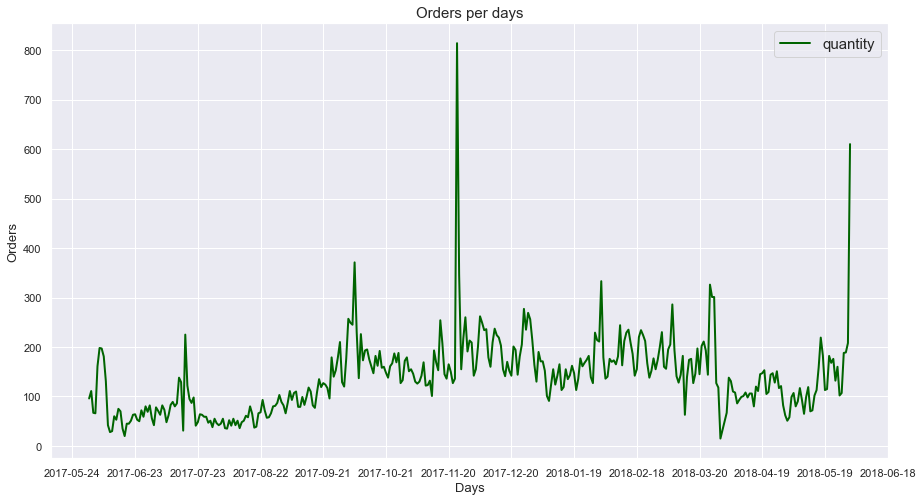

In [354]:
day(orders_days, 'Orders per days', 'Orders', 'quantity')

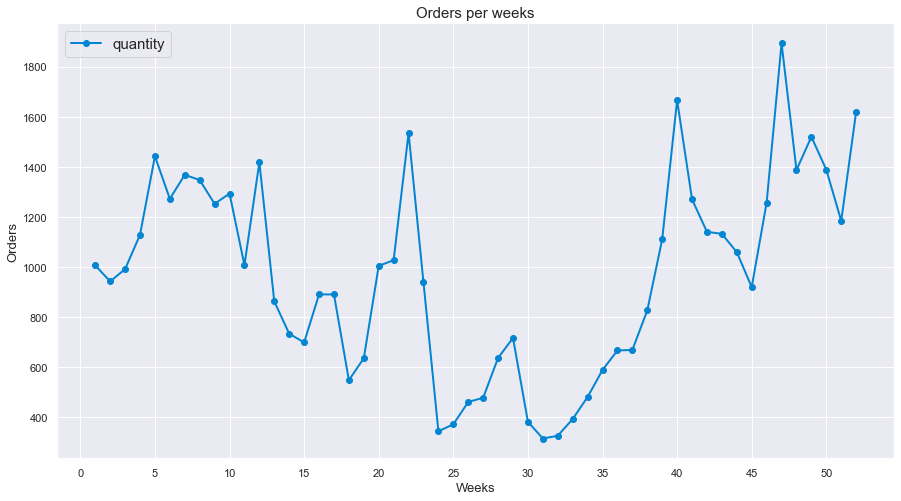

In [318]:
week(orders_weeks, 'Orders per weeks', 'Orders', 'quantity')

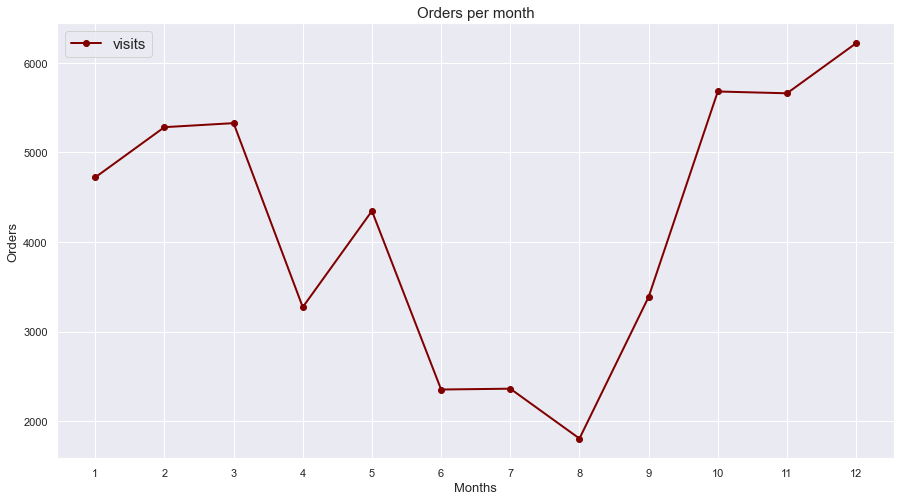

In [319]:
month(orders_months, 'Orders per month', 'Orders', 'quantity')

Графики покупок похожи на графики посещений. Скачки в те же периоды, спады в теже периоды. Все это стоило ожидать, ведь больше просмотров = больше шансов, что будут покупки!

Посмотрим теперь не наглядно, а численно.

In [320]:
print('Покупок в месяц в среднем:', int(orders_months.mean()))
print('Покупок в неделю в среднем:', int(orders_weeks.mean()))
print('Покупок в день в среднем:', int(orders_days.mean()))

Покупок в месяц в среднем: 4201
Покупок в неделю в среднем: 969
Покупок в день в среднем: 138


Я плохо разбираюсь сколько покупок должно быть в норме. Но 138 покупок в день кажется хорошим результатом. Однако это результаты с учетом пика активности. Вижно, что в преддекабрьский пик было аж 800 продаж. А пик в мае дал аж примерно 620 продаж.

In [321]:
orders

,buy_ts,revenue,uid,first_visit,first_buy,month,week,day
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,6,22,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,6,22,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,6,22,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,6,22,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,6,22,2017-06-01
...,...,...,...,...,...,...,...,...
50409,2018-05-31 23:43:00,3.67,1805512004303848280,2017-12-07 23:20:00,2018-05-31 23:43:00,5,22,2018-05-31
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 09:11:00,2018-05-31 23:50:00,5,22,2018-05-31
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:05:00,2018-05-31 23:50:00,5,22,2018-05-31
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:52:00,2018-05-31 23:54:00,5,22,2018-05-31


In [322]:
orders_mean_people = int(orders['uid'].count()) / int(orders['uid'].nunique()) 

In [323]:
print('Покупок на одного пользователя в среднем за все время:', int(orders_mean_people))

Покупок на одного пользователя в среднем за все время: 1


In [324]:
first_source = visits.sort_values(by = ['uid', 'starts_ts']).groupby('uid').agg({'source_id':'first'}) 
orders = orders.merge(first_source, on='uid',how='left')

In [325]:
source_orders_month = orders.groupby(['source_id','month']).agg({'uid':'count'})
source_orders_week = orders.groupby(['source_id','week']).agg({'uid':'count'})
source_orders_day = orders.groupby(['source_id','day']).agg({'uid':'count'})

In [326]:
source_orders_month = source_orders_month.pivot_table(index='month',
                                                      columns='source_id',
                                              values='uid',
                                              aggfunc='mean') 
source_orders_week = source_orders_week.pivot_table(index='week',
                                                    columns='source_id',
                                              values='uid',
                                              aggfunc='mean') 
source_orders_day = source_orders_day.pivot_table(index='day',
                                                  columns='source_id',
                                              values='uid',
                                              aggfunc='mean') 
# создали все сводные таблицы с данными

In [327]:
print('Среднее кол-во покупок ежедневно по рекламным источникам:')
print(source_orders_day.mean())
print()
print('Среднее кол-во покупок еженедельно по рекламным источникам:')
print(source_orders_week.mean())
print()
print('Среднее кол-во покупок ежемесячно по рекламным источникам:')
print(source_orders_month.mean())
print()

Среднее кол-во покупок ежедневно по рекламным источникам:
source_id
1     14.388430
2     17.608815
3     36.608815
4     35.618785
5     25.911846
7      1.000000
9      4.960843
10     4.776758
dtype: float64

Среднее кол-во покупок еженедельно по рекламным источникам:
source_id
1     100.442308
2     122.923077
3     255.557692
4     247.961538
5     180.884615
7       1.000000
9      31.673077
10     30.038462
dtype: float64

Среднее кол-во покупок ежемесячно по рекламным источникам:
source_id
1      435.250000
2      532.666667
3     1107.416667
4     1074.500000
5      783.833333
7        1.000000
9      137.250000
10     130.166667
dtype: float64



Анализируем полученные таблички.

1. Источник 4 самый популярный по среднему количеству покупок в любой период. 
2. Источники 1,2,3,5 тоже стараются не отставать по количеству покупок в среднем.
3. В источнике 7, как поняла, одна покупка. С одной стороны источник имеет смысл оставить, чтобы узнать окупился ли он. С другой стороны какой толк от источника, на который и заходят мало и покупка лишь одна? Поэтому я решила его просто удалить, чтобы он не мешался в дальнейшем анализе. Пока-пока рекламный источник 7, будем считать, что ты неэффективен.
4. Источники 9-10 все также малы и грустны. Может маленькие, да удаленькие? Не знаю.

Пока что лидеры и приоритеты - это рекламные источники 1-5.

In [328]:
orders = orders[orders['source_id'] != 7]

Продолжим смотреть, рассмотрим наши данные по месячным когортам. А точнее по месяцам, когда люди впервые делают покупку.

In [329]:
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['first_buy_month'] = orders['first_buy'].astype('datetime64[M]')
#создали дополнительные столбцы, где будет месяц активности и первой активности
orders['cohort_lifetime'] = orders['buy_month'] - orders['first_buy_month']
orders['cohort_lifetime'] = orders['cohort_lifetime'] / np.timedelta64(1,'M')
orders['cohort_lifetime'] = orders['cohort_lifetime'].round().astype('int') 
#расчитали cohort_lifetime и привели к нужному типу, получились lifetime от 0 до 11, где 0 - месяц зарождения когорты
cohorts = orders.groupby(['first_buy_month','cohort_lifetime']).agg({'uid':'count'}).reset_index() 
cohorts['first_buy_month'] = cohorts['first_buy_month'].dt.strftime('%Y-%m')
#сгруппировали когорты
#initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_order_month','uid']]
#initial_users_count.columns = ['first_order_month', 'initial_uid']
#создали доп.переменную, в которой оставили дату первой активности и количество пользователей на первую дату активности
#cohorts = cohorts.merge(initial_users_count,on='first_order_month')

purchase = cohorts.pivot_table(index='first_buy_month',
                                      columns='cohort_lifetime',
                                      values='uid')
#сделали сводную таблицу по retention и вывели ее для наглядности
purchase.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
2017-07,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,
2017-08,1532.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,,
2017-09,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,,,
2017-10,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,,,,
2017-11,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,,,,,
2017-12,5052.0,270.0,202.0,179.0,86.0,105.0,,,,,,
2018-01,3783.0,224.0,159.0,64.0,78.0,,,,,,,
2018-02,4095.0,222.0,83.0,70.0,,,,,,,,


In [330]:
purchase.apply(pd.to_numeric, downcast='integer')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,2354,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
2017-07,2186,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2017-08,1532,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN,NaN
2017-09,2933,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN,NaN,NaN
2017-10,4964,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN,NaN,NaN,NaN
2017-11,4813,397.0,182.0,211.0,136.0,59.0,102.0,NaN,NaN,NaN,NaN,NaN
2017-12,5052,270.0,202.0,179.0,86.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3783,224.0,159.0,64.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4095,222.0,83.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [331]:
purchase.apply(pd.to_numeric, downcast='integer')
purchase.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
2017-07,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,
2017-08,1532.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,,
2017-09,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,,,
2017-10,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,,,,
2017-11,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,,,,,
2017-12,5052.0,270.0,202.0,179.0,86.0,105.0,,,,,,
2018-01,3783.0,224.0,159.0,64.0,78.0,,,,,,,
2018-02,4095.0,222.0,83.0,70.0,,,,,,,,


In [381]:
def heatmap(df, title):
    sns.set(font_scale=1.1)
    plt.figure(figsize=(12, 8))
    plt.title(f'{title}', fontsize=15)
    sns.heatmap(df, annot=True, fmt='.1f', linewidths=1, linecolor='white', cmap= 'viridis');

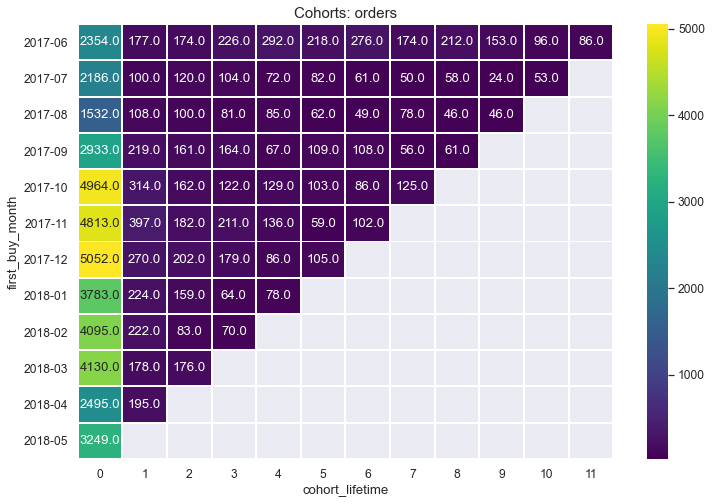

In [382]:
heatmap(purchase, 'Cohorts: orders')

Начнем с того, что я понятия не имею как в сводной таблице в первом столбце нулевой когорты появились.. нули. Поэтмоу мне пришлось везде добавлять нули. Еще я не знаю как увеличиьт размер самих ячеек со значениями, но ничего, вроде понятно. Да и шрифт ячеек хотелось бы пожирнее...

Приступим к анализу.
Самые пики видны в октябре и в декабре по количеству покупок. Вспоминаем наш график и соглашаемся, да, все так и есть. Да и в принципе видно, что первый месяц жизни когорт прошел успешно. Что нельзя сказать о других. В каких-то когортах видно, что со временем продажи и падают и растут, но все они не так высоки. И даже в самой "популярной" декабрьской когорте после нулевого месяца жизни больше 270 покупок в месяц и не было. С другой стороны: ура, люди хотя бы покупают! Но могут покупать больше (или должны покупать больше?)

In [66]:
cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 3 columns):
first_buy_month    78 non-null object
cohort_lifetime    78 non-null int64
uid                78 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.0+ KB


**Какой средний чек?** <a name="m2.2.3"></a>

Средний чек я решила посмотреть также по периодам день, неделя месяц, а также по месячной когорте и месячный средний чек по рекламным источникам. По среднему количеству покупок мы узнали, что если какие-то рекламные источники и лидируют, то лидируют они как по дням и неделям, так и по месяцу.

In [338]:
# по месяцам
average_check_months = orders.groupby(['month']).agg({'uid':'count', 'revenue':'sum'})
average_check_months['revenue_per_user'] = average_check_months['revenue'] / average_check_months['uid']
average_check_months = average_check_months.pivot_table(index='month',
                                              values='revenue_per_user',
                                              aggfunc='mean') 
# по неделям
average_check_weeks = orders.groupby(['week']).agg({'uid':'count', 'revenue':'sum'})
average_check_weeks['revenue_per_user'] = average_check_weeks['revenue'] / average_check_weeks['uid']
average_check_weeks = average_check_weeks.pivot_table(index='week',
                                              values='revenue_per_user',
                                              aggfunc='mean') 
# по дням
average_check_days = orders.groupby(['day']).agg({'uid':'count', 'revenue':'sum'})
average_check_days['revenue_per_user'] = average_check_days['revenue'] / average_check_days['uid']
average_check_days = average_check_days.pivot_table(index='day',
                                              values='revenue_per_user',
                                              aggfunc='mean') 

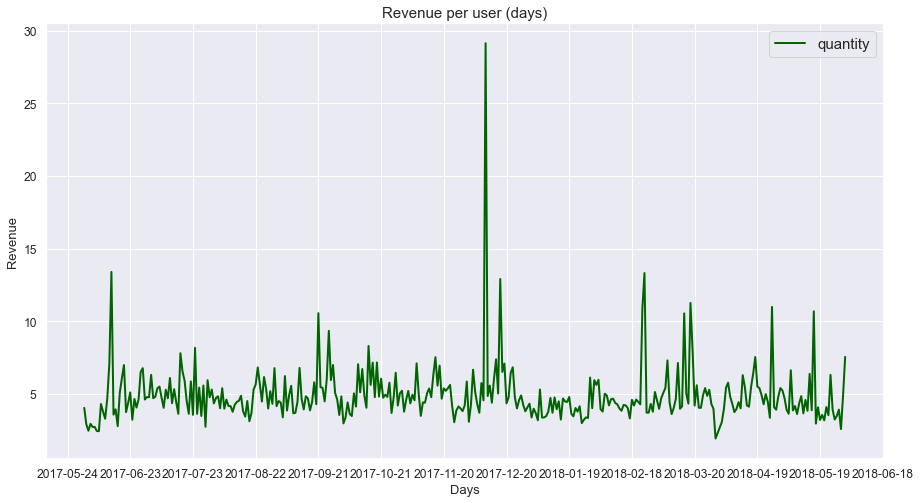

In [411]:
day(average_check_days, 'Revenue per user (days)', 'Revenue', 'quantity')

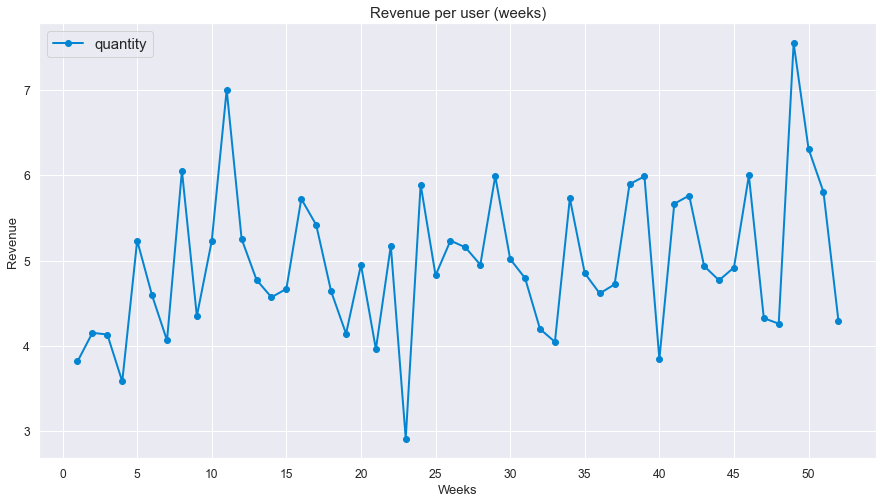

In [412]:
week(average_check_weeks, 'Revenue per user (weeks)', 'Revenue', 'quantity')

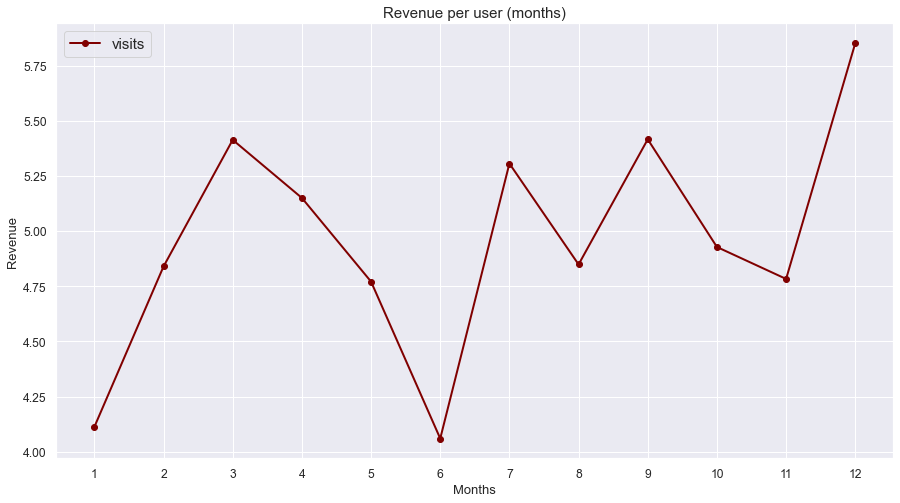

In [410]:
month(average_check_months, 'Revenue per user (months)', 'Revenue', 'quantity')

Средний чек за весь период

In [340]:
check_months = orders.groupby(['month']).agg({'uid':'count', 'revenue':'sum'})
check_months = check_months['revenue'].sum() / check_months['uid'].sum()

check_weeks = orders.groupby(['week']).agg({'uid':'count', 'revenue':'sum'})
check_weeks = check_weeks['revenue'].sum() / check_weeks['uid'].sum()

check_days = orders.groupby(['day']).agg({'uid':'count', 'revenue':'sum'})
check_days = check_days['revenue'].sum() / check_days['uid'].sum()

In [341]:
display(check_months)
display(check_weeks)
display(check_days)

4.999753238252008

4.999753238252034

4.9997532382520395

In [342]:
orders['revenue'].mean()

4.99975323825199

Средний чек не зависит от месяца, недели или дня. Он везде 4 монетки (буду называть монетками). А это значит, что если у нас и есть пик в 10-30 монеток за день, то остальные дни видимо не шибко прибыльные.

Также можно заметить, что месячный график изменился. Он теперь не поломанная парабола, а какие-то горы. Все из-за того, что в июне месяце хоть и были покупки, но, видимо, дешевые. Также резкая просадка по среднему чеку в январе, хотя по покупкам январь не менее популярнее декабря. Да и февраль что-то остает. Распродажи? Незивестно. А вот в июле и августе покупок было мало, а денег пришло больше. Вот оно волшебство!

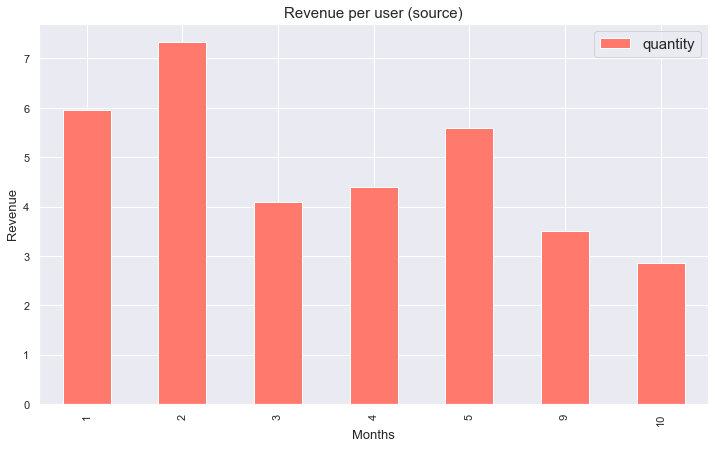

In [343]:
average_by_source = orders.groupby(['source_id']).agg({'uid':'count', 'revenue':'sum'})
average_by_source['revenue'] = average_by_source['revenue'].astype('int')
average_by_source['revenue_per_user'] = average_by_source['revenue'] / average_by_source['uid']
average_by_source = average_by_source.pivot_table(index='source_id',
                                              values='revenue_per_user',
                                              aggfunc='mean') 

sns.set()
ab_s = average_by_source.plot(figsize=(12,7), kind='bar', color = '#ff796c');
ab_s.set_title('Revenue per user (source)', fontsize=15);
ab_s.set_xlabel('Months', fontsize=13);
ab_s.set_ylabel('Revenue', fontsize=13);
ab_s.legend(['quantity'], prop={'size': 15});

Возвращаемся к нашим источникам и смотрим средний чек в месяц. Сразу видно, что средний чек источников 1 и 2 больше всех. Покупают удачно, нам же лучше. А может рекламный источник попал в ЦА? Хотя я плохо разбираюсь как бы действовало ЦА в таком случае, лишь мое предположение. Остальные источники, даже грустные 9-10, имеют примерно одинаковый средний чек.

In [344]:
orders_grouped = orders.groupby(['first_buy_month',
                                            'buy_month']).agg({'revenue':'sum','uid':'count'})
# находим средний чек
orders_grouped['revenue_per_user'] = orders_grouped['revenue'] / orders_grouped['uid'] 
# расчитываем cohort_lifetime
orders_grouped = orders_grouped.reset_index()
orders_grouped['cohort_lifetime'] = orders_grouped['buy_month'] - orders_grouped['first_buy_month']
orders_grouped['cohort_lifetime'] = orders_grouped['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped['cohort_lifetime'] = orders_grouped['cohort_lifetime'].round().astype('int')
orders_grouped['first_buy_month'] = orders_grouped['first_buy_month'].dt.strftime('%Y-%m')
# делаем сводную таблицу
revenue_per_user = orders_grouped.pivot_table(index='first_buy_month',
                                              columns='cohort_lifetime',
                                              values='revenue_per_user',
                                              aggfunc='mean') 

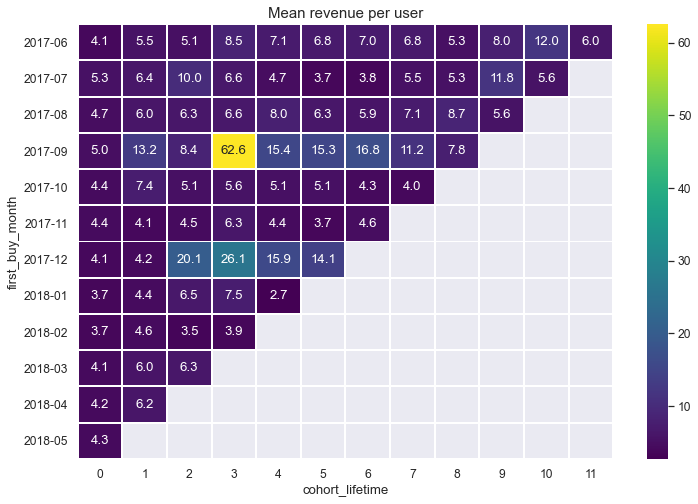

In [383]:
heatmap(revenue_per_user, 'Mean revenue per user')

Вот он огонек надежды! В декабре сентябрьская когорта решила, что пора покупать.  Теперь мы почти знаем этих людей, которые украсили нам скачки близь декабря и увеличили средние показатели декабря везде. Но радоваться ради одной победы - это как сидеть лицом в грязи и думать, что ухо не запачкалось. По остальным критериям средний чек в районе 5-6 монеток. И лишь весной декабрьская когорта ожила и решила что-то уверенно покупать (как жаль, что другие когорты не решили).

**Сколько денег приносят (LTV)?** <a name="m2.2.4"></a>

LTV будем смотреть по месячным когортам и рекламным источникам. 

In [364]:
costs['month'] = costs['dt'].astype('datetime64[M]') 
# у costs выделяем месяц для построения месячной когорты/
cohort_sizes = orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
# создаем переменную размера когорты,
# в которой будет количество уникальных пользователей на начальной стадии когорты
cohorts = orders.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
# делаем когорты из полученной таблицы orders_new и находим сумму revenue
cohorts = pd.merge(cohort_sizes, cohorts, on='first_buy_month')
# мерджим когорты и размер когорты

In [365]:
margin_rate = 1 # не дана изначально, принимаем за 100%
cohorts ['gp'] = cohorts ['revenue'] * margin_rate
# рассчитываем валовую прибыль, в нашем случае валовая прибыль равна выручке
cohorts ['age'] = (cohorts ['buy_month'] - cohorts ['first_buy_month']) / np.timedelta64(1, 'M')
cohorts ['age'] = cohorts ['age'].round().astype('int')
# находим возраст когорты и приводим с int типу, возраст означает сколько месяцев когорта прожила (от 0 до 11)
cohorts ['ltv'] = cohorts ['gp'] / cohorts ['n_buyers']  
cohorts['first_buy_month'] = cohorts['first_buy_month'].dt.strftime('%Y-%m')
# теперь находим ltv

In [366]:
ltv_pivot = cohorts.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2).cumsum(axis=1) 
ltv_pivot.fillna('') 
# получили вот такую сводную таблицу с накопительным LTV

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.44,11.05,11.62,11.88
2017-07,6.01,6.35,6.97,7.33,7.51,7.67,7.79,7.93,8.09,8.24,8.4,
2017-08,5.28,5.75,6.21,6.6,7.09,7.37,7.58,7.99,8.28,8.47,,
2017-09,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.43,,,
2017-10,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11,5.15,5.55,5.75,6.07,6.22,6.27,6.38,,,,,
2017-12,4.74,5.0,5.93,7.0,7.31,7.65,,,,,,
2018-01,4.14,4.43,4.73,4.87,4.93,,,,,,,
2018-02,4.16,4.44,4.52,4.59,,,,,,,,


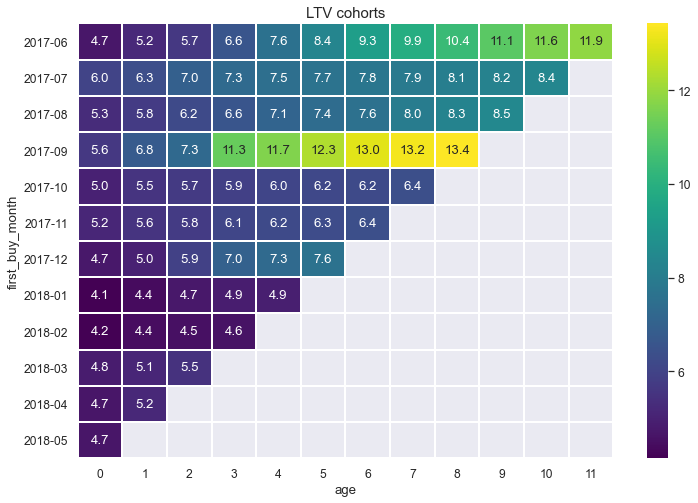

In [384]:
heatmap(ltv_pivot, 'LTV cohorts')

Получили подобную тепловую карту. LTV самый успешный у июньской когорты и у сентябрьской. Я бы и сказала, что "Июньская когорты успешна, потому что живет дольше всех", но вот июльская когорта живет на месяц меньше, а уже не такая успешная, хотя старт когорты был успешнее старта июньской когорты. Также в сентябрьской когорты резкий скачок LTV в декабре. Но мы видели, что средний чек декабря у сентябрьской когорты больше всех.

Когорты январь-май самые менее ценные, но и живут они меньше всего. Если сравнивать когорты, котоорые живут по 6+ месяцев, то картина по цифрам, в принципе, не изменится. Лидера будут те же.

Означает ли, что большое LTV = нужно привлекать людей в эти сезоны? Возможно. Но окупается ли когорта? Узнаем дальше.

Посмотрим LTV по рекламным источникам.

In [368]:
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(first_source, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
cohort_sizes_source = payers.groupby('source_id').agg({'uid': 'nunique'}).reset_index()
cohort_sizes_source.columns = ['source_id', 'n_buyers']
# размер когорты по источникам
cohorts_source = orders.groupby(['buy_ts', 'first_buy', 'source_id']).agg({'revenue': 'sum'}).reset_index()
# когорты по источникам 
cohorts_source = pd.merge(cohort_sizes_source, cohorts_source, on='source_id')
# мерджим

In [369]:
margin_rate = 1 # не дана изначально, принимаем за 100%
cohorts_source ['gp'] = cohorts_source ['revenue'] * margin_rate
# рассчитываем валовую прибыль, в нашем случае валовая прибыль равна выручке
cohorts_source ['age'] = (cohorts_source ['buy_ts'] - cohorts_source ['first_buy']) / np.timedelta64(1, 'M')
cohorts_source ['age'] = cohorts_source ['age'].round().astype('int')
# находим возраст когорты и приводим с int типу, возраст означает сколько месяцев когорта прожила (от 0 до 11)
cohorts_source ['ltv'] = cohorts_source ['gp'] / cohorts_source ['n_buyers']  
# теперь находим ltv

In [370]:
cs_pivot = cohorts_source.pivot_table(
        index='source_id', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').fillna(0)
cs_pivot = cs_pivot.cumsum(axis = 1).round(2)

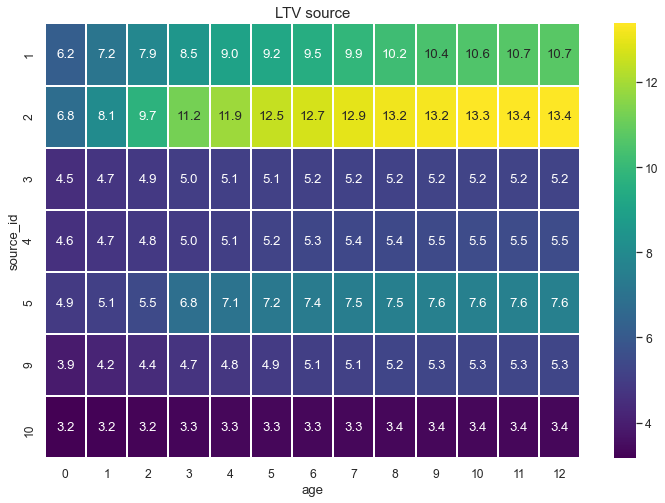

In [385]:
heatmap(cs_pivot, 'LTV source')

Все наши рекламные источники (когорты по рекламным источникам) жили одинаковое количество времени. Однако:
1. Источники 1-2 имеют более ценных клиентов, но, как мы помним, там больше всех средний чек.
2. Источники 3-5 даже при больших просмотрах и большем количестве средних покупок имеют менее ценных клиентов. 
3. Источник 10 совсем грустный, обнять и плакать.
4. Источник 9 по ценности клиентов схож с источниками 3-5.

In [391]:
first_device = visits.sort_values(by = ['uid', 'starts_ts']).groupby('uid').agg({'device':'first'}) 
orders = orders.merge(first_device, on='uid',how='left')
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(first_device, on = 'uid')
payers = payers.rename(columns = {'buy_ts': 'first_buy'}).reset_index()
cohort_sizes_device = payers.groupby('device').agg({'uid': 'nunique'}).reset_index()
cohort_sizes_device.columns = ['device', 'n_buyers']
cohorts_device= orders.groupby(['buy_ts', 'first_buy', 'device']).agg({'revenue': 'sum'}).reset_index()
cohorts_device = pd.merge(cohort_sizes_device, cohorts_device, on='device')
margin_rate = 1 # не дана изначально, принимаем за 100%
cohorts_device ['gp'] = cohorts_device ['revenue'] * margin_rate
# рассчитываем валовую прибыль, в нашем случае валовая прибыль равна выручке
cohorts_device ['age'] = (cohorts_device ['buy_ts'] - cohorts_device ['first_buy']) / np.timedelta64(1, 'M')
cohorts_device ['age'] = cohorts_device ['age'].round().astype('int')
# находим возраст когорты и приводим с int типу, возраст означает сколько месяцев когорта прожила (от 0 до 11)
cohorts_device ['ltv'] = cohorts_device ['gp'] / cohorts_device ['n_buyers']  
cd_pivot = cohorts_device.pivot_table(
        index='device', 
        columns='age', 
        values='ltv', 
        aggfunc='sum').fillna(0)
cd_pivot = cd_pivot.cumsum(axis = 1).round(2)

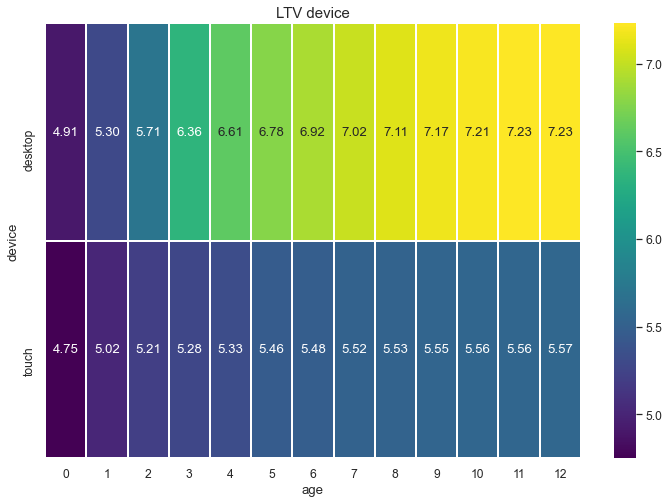

In [392]:
sns.set(font_scale=1.1)
plt.figure(figsize=(12, 8))
plt.title('LTV device', fontsize=15)
sns.heatmap(cd_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap= 'viridis');

***Общий вывод продаж***

Рекламные источники. 
1. И хотя по визитам самые популярные источники были 3-5, то дальше при анализе на моменте "средний чек" источники начали сдавать позиции. Среднее количество там все еще больше (теория: больше визитов = больше вероятность, что будет больше покупок), но средний чек - нет. Видимо покупали мало и дешево. Следовтельно LTV тоже не самый хороший.
2. Выяснила, что 6 рекламный источник не приносит покупок, а 7 рекламный источник з авесь год принес одну покупку, которую пришлось удалить, чтобы на картине не было "А ВОТ В ИСТОЧНИКЕ 7 LTV ТАК ХОРОШ". Сделала себе пометку, что рекламные источники 6 и 7 плохи как минимум по посещению и считаю некорректным смотреть ROMI седьмого источника по одной покупке. 
3. А вот источники 1-2 хоть и имели средние просмотры и среднее место среднего (какая тавтология) количества покупок, но привели пользователей, готовых отдать большие деньги за один заказ. Потому что средний чек и LTV этих рекламных источников лучше всех (а привлекаем с рекламных источников мы именно покупки).

Месячные когорты.
1. Месячные когорты дают представление о том, в какой именно месяц успешность привлечение клиентов.
2. По нашим месячным когортам самыми успешными по ценности клиентов (LTV) стали когорты июня и сентября.
3. По среднему чеку все когорты примерно одинаковы, но в декабрьской и сентябрьской когорте виднеются взлеты в какие-то месяцы в 4-10 раз.

### Маркетинг <a name="m2.3"></a>

**Сколько денег потратили? Всего / на каждый источник / по времени** <a name="m2.3.1"></a>

Маркетинг анализируем с помощью costs и частично orders.

In [393]:
print('Всего потрачено на маркетинг:', int(costs['costs'].sum()))

Всего потрачено на маркетинг: 329131


Суммарно более 300 тысяч монеток потрачено на маркетинг. Нормально так! Теперь будем смотреть по источникам и времени.

In [394]:
costs_source = costs.groupby('source_id').agg({'costs':'sum'})

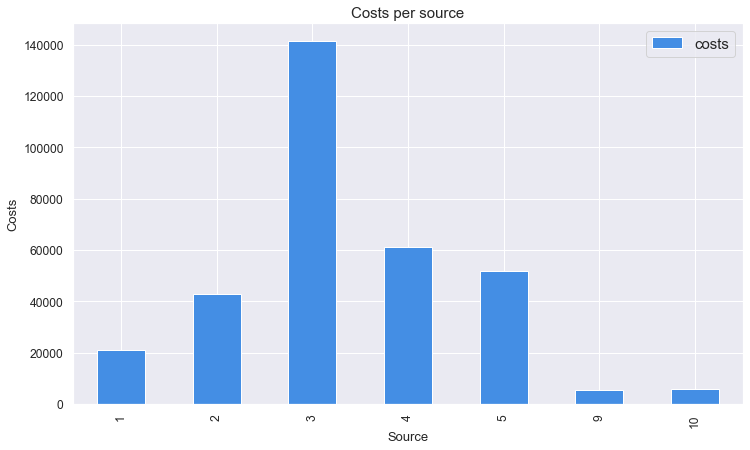

In [395]:
cs = costs_source.plot(figsize=(12,7), color = '#448ee4', kind='bar');
cs.set_title('Costs per source', fontsize=15);
cs.set_xlabel('Source', fontsize=13);
cs.set_ylabel('Сosts', fontsize=13);
cs.legend(['costs'], prop={'size': 15});

Я решила, что достаточно будет столбчатой диаграммы, чтобы посмотреть самые затратные по маркетингу источники. И.. самый затратный источник 3, 140000 или почти 50% от общей суммы. На втором месте источники 4-5, затем источники 1-2 и источники 9-10 менее затратные. 

Интересное замечание: нет источников 6 и 7, хотя в данной таблице мы не делали никаких манипуляций. Видимо в эти источники и не вкладывались или забыли учесть вклад. 

<div class="alert alert-block alert-success">
    

### Комментарий от ревьюера №2

Всё верно.
</div>

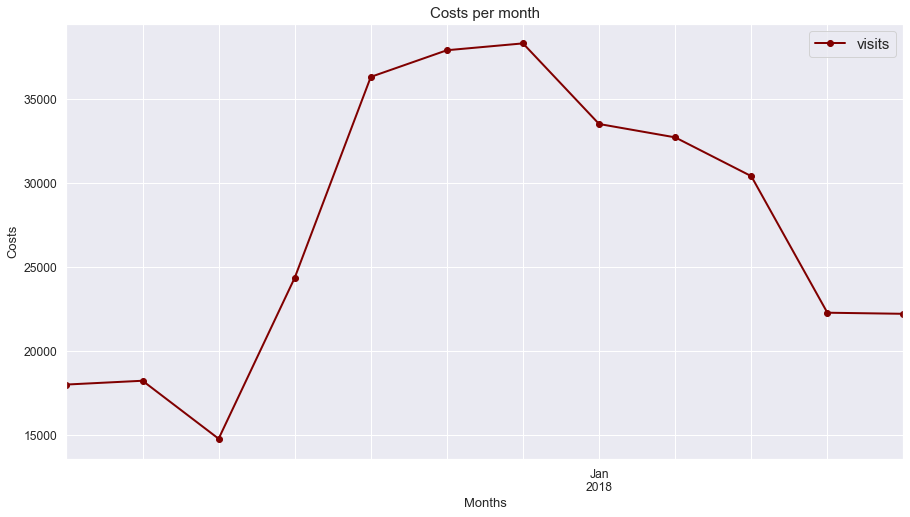

In [396]:
costs_months = costs.groupby('month').agg({'costs':'sum'})
month(costs_months, 'Costs per month', 'Сosts', 'count costs')

Самый затратный по привлечению период - это октябрь-март. Летом на привлечение денег оставляют меньше всего, но и просмотров меншье всего. Май выдался волшебным: влоежно мало, а пики замечены были.

**Сколько стоило привлечение одного покупателя из каждого источника?**

Также рассматриваем месячные когорты и рекламные источники.

In [397]:
cohorts['first_buy_month'] = pd.to_datetime(cohorts['first_buy_month'])

In [398]:
monthly_costs = costs.groupby('month').agg({'costs':'sum'})
# расчитываем расходы за месяц
cohorts = pd.merge(cohorts, monthly_costs, left_on='first_buy_month', right_on='month')
# создаем таблицу, объединив нашу прошлую когорту и месячные маркетинговые расходы
cohorts['cac'] = cohorts['costs'] / cohorts['n_buyers']
# расчитываем cac по когортам

In [399]:
cohorts.groupby('first_buy_month').agg({'cac':'mean'})

,cac
first_buy_month,
2017-06-01,8.905091
2017-07-01,9.485486
2017-08-01,10.803901
2017-09-01,9.441654
2017-10-01,8.369327
2017-11-01,9.288870
2017-12-01,8.741809
2018-01-01,9.937302
2018-02-01,8.962758


В среднем на привлечение одного пользователя в месячной когорте уходит 9.3 монетки. Самое дешевое привлечение у майской когорты, но она и живет лишь один месяц. А вот самое дорогое привлечение августовской когорты. И хотя средний чек в августе был не так мал, но мы привлекли очень мало покупок, отсюда и такой "ценник" на покупателя.

In [400]:
monthly_costs_source = costs.groupby('source_id').agg({'costs':'sum'}).merge(cohort_sizes_source, on = 'source_id')
monthly_costs_source['cac'] = monthly_costs_source['costs'] / monthly_costs_source['n_buyers']
monthly_costs_source = monthly_costs_source.set_index('source_id')

In [401]:
monthly_costs_source

,costs,n_buyers,cac
source_id,,,
1,20833.27,2899,7.186364
2,42806.04,3506,12.209367
3,141321.63,10473,13.493901
4,61073.60,10295,5.932356
5,51757.10,6931,7.467479
9,5517.49,1088,5.071222
10,5822.49,1329,4.381106


По рекламным источникам картина вполне ожидаемая. Самое дорогое привлечение у 9 и 10 источника. **ДОПИСАТЬ**

**На сколько окупились расходы? (ROI)**

In [402]:
cohorts['romi'] = cohorts['ltv'] / cohorts['cac']
# считаем ROMI по месячным когортам
romi_pivot = cohorts.pivot_table(
        index='first_buy_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)
romi_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


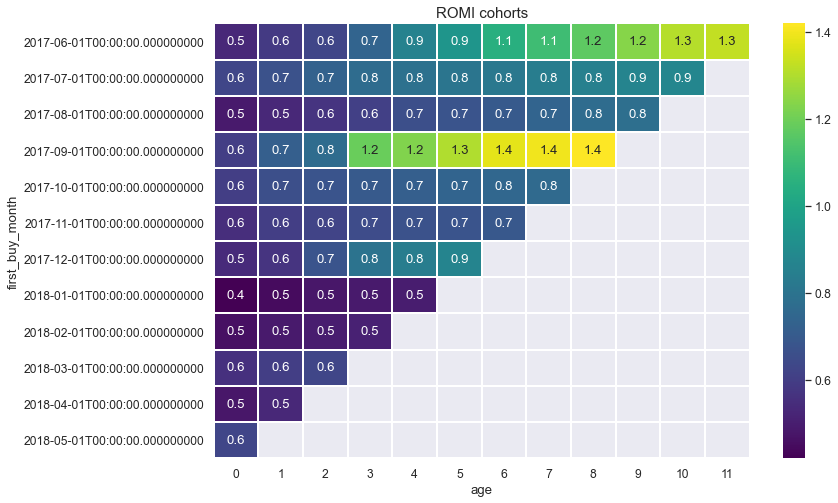

In [403]:
heatmap(romi_pivot, 'ROMI cohorts')

Неудивительно, но самые окупаемые быстро месячные когорты - это июнь и сентябрь. Июнь окупился уже на 7-й месяц, а сентяюрт окупился аж на 4-й месяц. Несколько когорт блиизки к окупаемости, а некоторые когорты, у которых жизнь меньше полугода, не будем оценивать. Им еще жить и жить.

В теории учили, что также можно смотреть среднее ROMI, чтобы сказать когда примерно каждая когорта окупается. Не знаю насколько это корректно, но я решила ее сделать.

In [405]:
romi_pivot.mean(axis=0)

age
0     0.540833
1     0.582727
2     0.629000
3     0.717778
4     0.783750
5     0.860000
6     0.898333
7     0.970000
8     1.052500
9     0.963333
10    1.095000
11    1.330000
dtype: float64

И если верить подобной табличке, но все когорты окупятся к 9-му месяцу жизни, хотя и на 10-й смесяц немного просядут, потом зато вернутся в строй и будут нарастать.

Считаю, что средняя окупаемость к 9-ми месяцу - это довольно долго. Но у меня мало знаний в области бизнеса, чтобы судить так узко. Мое дело сейчас рассмотреть ROMI и скачать что успешнее, а что - нет.

In [406]:
romi = cs_pivot.merge(monthly_costs_source[['cac']], on = 'source_id')
romi = romi.div(romi['cac'], axis = 0).drop(columns = 'cac')

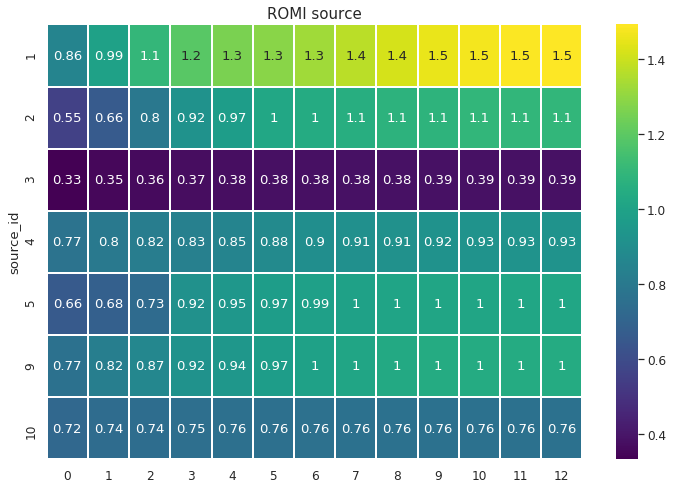

In [101]:
sns.set(font_scale=1.1)
plt.figure(figsize=(12, 8))
plt.title('ROMI source', fontsize=15)
sns.heatmap(romi, annot=True, linewidths=1, linecolor='white', cmap= 'viridis'); 

ROMI по рекламным источникам я считала точно также, как и ROMI по месячным когортам. И у меня вышло, что ни один рекламный источник себя не окупает. Дела, думаю, плохи! Самый более ли менее окупаемый источник - это 1-й и 2-й. А вот 3-й источник самый затратный по маркетингу и, соответственно, себя совсем не окупил ни в какой месяц.

### Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?
<a name="m3"></a>

Я знаю, что мой проект не идеален и нужно где работать. Например я до сей пор не уверена в ROMI по рекламным источникам. Мне кажется, что что-то должно окупиться, но нет.. Поэтмоу напишу краткий вывод, а после проверки его дополню полноценно.

* **Девайсы:**:
По нашему анализы мы узнали, что больше на сервис заходят через desktop. Однако на продолжительность сессии это не влияет, 1 минута. Я не стала смотреть средний чек девайса и все остальное, потому что товар можно продать откуда угодно, главное его продать. Длительность сессии на графике и в принципе посещаемость показала, что заходят на девайсы почти пропорционально, а значит проблем со входом на какое-то устройство нет. Советовать касательно того какую платформу выбрать не буду, потому что обе платформы приносят клиентов. P.S. Возможно следовало посмотреть все же хотя бы количество покупок, мало ли просадки все же есть... 

* **Рекламные источники:**
Проблемная тема проекта из-за странного ROMI в конце. Но даже если брать все то, что узнали, то про источники 6 и 7 нужно посмотреть, что там за источники с 0 вкладом в маркетинг, но которые приносят почти один десятую человека в среднем в день. Источники 9-10 стоит пересмотреть, я бы советовала убрать эти источники и вложиться в более прибыльные. А вот у источника 3 пересмотреть зартаты, потому что ROMI этого источника всегда по нулям. Просмотром, конечно, много, но средний чек скуден. А на просмотрах не покушаешь. Источники, на которые СТОИТ обратить внимание - это источники 1 и 2. У них немного просмотров и покупок, но люди готовы вкладывать в покупки большие деньги. ROMI этих исочников краше всех.

* **Месячные когорты:**
Если мы говорим о месяцах, когда стоит привлекать, то явный лидер - это сентябрь. Средний чек сентябрьской когорты в декабре возрос с космической скоростью и держался приятно много еще несколько месяцев. Также июньская когорта показала себя хорошо, но то ли дело в том, что это самая старая когорта, то ли дело в том, что она и правда успешна. Касательно ROMI, то самые быстро окупаемые когорты все еще сентябрьская (1 место) и июньская. 